In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


Load Admission Dataset

In [2]:
df1 = pd.read_csv("Admission_Predict_Ver1.1.csv").iloc[:,1:]
df2 = pd.read_csv("Admission_Predict.csv").iloc[:,1:]
df = pd.concat([df1, df2]).drop_duplicates()
df = df.rename(columns={"LOR " : "LOR", "Chance of Admit ": "Chance of Admit"})
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


## EDA

#### Feature Selection: for this excercise we defined the target variable "Chance of admit"; as it is shown, there are no missing data so it is not necessary to impute values; also, it is noted that some variables are int64 while others are float64 type, which are suitable data types for the models selected in the further section,

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 35.2 KB


In [68]:
df.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


#### Feature Selection: As a proxy to the predictive power, we selected the Pearson's correlation to select the variables that are more likely to explain the dataset variance. This is performed by building a correlation matrix, 

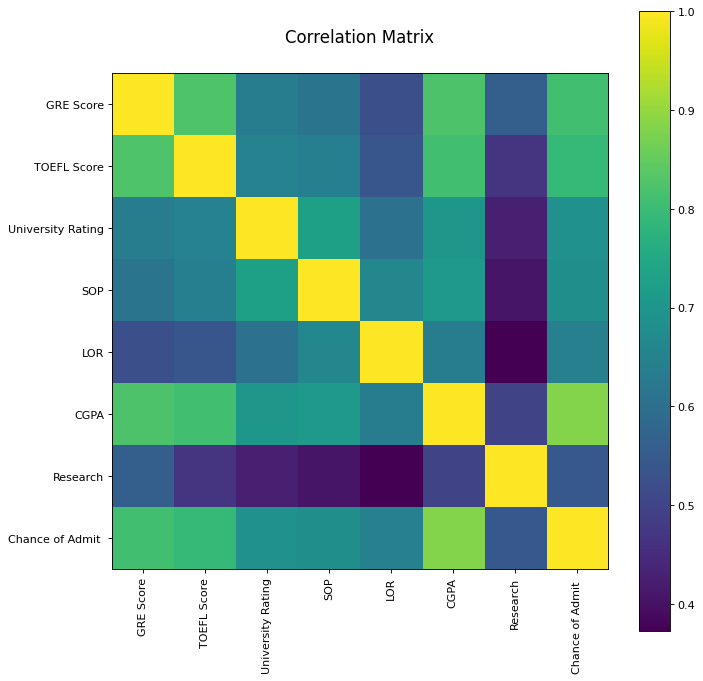

In [62]:
plot_correlation_matrix(df, 10)

##### As visualized in the above heatmap, comparing with the target variable, the feature with the highest absolute Pearon correlation is CGPA, followed by GRE Score, TOEFL Score and University Rating. Other categorical variables like Research have very poor correlation compared to the other features so they were excluded in the selection process. The selected features to build this model were: "CGPA", "GRE Score" , "University Rating", "SOP" and "LOR"; we excluded some variables like "TOEFL Score" as it is strongly correlated to the selected variables and this might have an impact on the model's performance. 

In [64]:
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


In [69]:
df = df[["CGPA", "GRE Score" , "University Rating", "SOP", "LOR", "Chance of Admit"]]

#### Feature extraction:  We created representative features given our personal criteria; the feature "GRE Score / University Rating" as both are two of the most correlated variables with the feature; also we built the categorical variable "High GRE Score" that indicates if the corresponding "GRE Score" is located at Q1 of the GRE Score distribution; adding these variables increases the probability of convergence for the optimization process in a supervised learning approach.

In [70]:
def feature_engineering(df):
    df["CGPA / Univesity Rating"] = df["CGPA"] / df["University Rating"]
    df["High GRE Score"] = df["GRE Score"] >= 320
    return df

df = feature_engineering(df)
df

<ipython-input-70-7da2cf58473b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CGPA / Univesity Rating"] = df["CGPA"] / df["University Rating"]


,CGPA,GRE Score,University Rating,SOP,LOR,Chance of Admit,CGPA / Univesity Rating,High GRE Score
0,9.65,337,4,4.5,4.5,0.92,2.412500,True
1,8.87,324,4,4.0,4.5,0.76,2.217500,True
2,8.00,316,3,3.0,3.5,0.72,2.666667,False
3,8.67,322,3,3.5,2.5,0.80,2.890000,True
4,8.21,314,2,2.0,3.0,0.65,4.105000,False
...,...,...,...,...,...,...,...,...
495,9.02,332,5,4.5,4.0,0.87,1.804000,True
496,9.87,337,5,5.0,5.0,0.96,1.974000,True
497,9.56,330,5,4.5,5.0,0.93,1.912000,True
498,8.43,312,4,4.0,5.0,0.73,2.107500,False


In [24]:
# Correlation matrix
def plot_correlation_matrix(df, width):

    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
   
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    
    plt.figure(num=None, figsize=(width, width), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()